In [1]:
# Importera alla nödvändiga bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

# Ladda MNIST-data
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

print(f"Data laddat: X shape = {X.shape}, y shape = {y.shape}")

# Förbered data för ANN
# Skapa train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                                              test_size=0.2, 
                                                                              random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                                    y_train_val, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

# Normalisera data (0-1 istället för 0-255) ( gör det snabbare att träna)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Konvertera labels till one-hot encoding ( vi gör om det till (10) så ANN output blir 10)
y_train_categorical = to_categorical(y_train, 10)
y_val_categorical = to_categorical(y_val, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"Träningsdata shape: {X_train.shape}")
print(f"Valideringsdata shape: {X_val.shape}")
print(f"Testdata shape: {X_test.shape}")

Data laddat: X shape = (70000, 784), y shape = (70000,)
Träningsdata shape: (44800, 784)
Valideringsdata shape: (11200, 784)
Testdata shape: (14000, 784)


Trial 30 Complete [00h 04m 14s]
val_accuracy: 0.981071412563324

Best val_accuracy So Far: 0.981071412563324
Total elapsed time: 00h 45m 55s

Bästa hyperparametrar:
- num_layers: 2
- units_0: 128
- use_dropout_0: True
- learning_rate: 0.0005
- dropout_0: 0.2
- units_1: 256
- use_dropout_1: True
- units_2: 64
- use_dropout_2: True
- dropout_1: 0.2
- dropout_2: 0.30000000000000004
- tuner/epochs: 20
- tuner/initial_epoch: 0
- tuner/bracket: 0
- tuner/round: 0
Epoch 1/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.8842 - loss: 0.3898 - val_accuracy: 0.9488 - val_loss: 0.1734
Epoch 2/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9461 - loss: 0.1768 - val_accuracy: 0.9619 - val_loss: 0.1258
Epoch 3/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9594 - loss: 0.1312 - val_accuracy: 0.9676 - val_loss: 0.1065
Epoch 4/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9668 - loss: 0.1076 - val_accuracy: 0.9704 - val_loss: 0.0964
Epoch 5/20
1400/

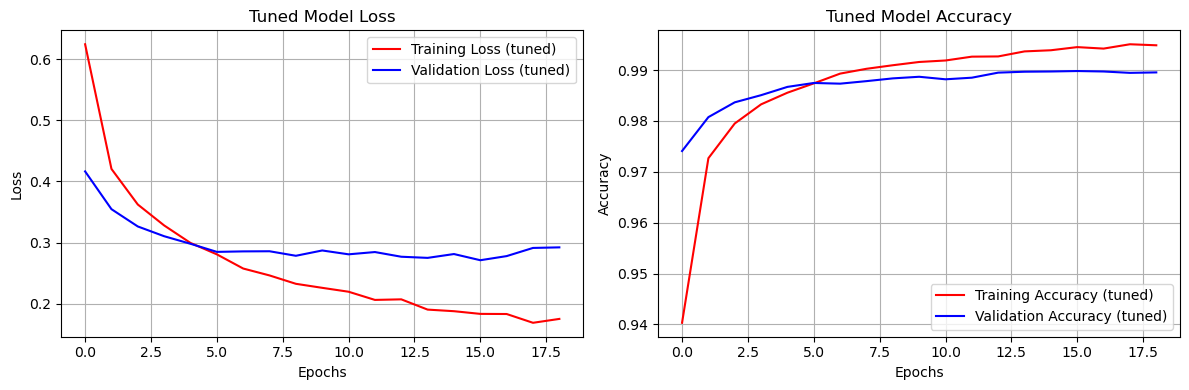

In [ ]:
# KerasTuner: definiera sökutrymme och tuner
import keras_tuner as kt

# Byggnadsfunktion för modellen att tunas
def build_model(hp: kt.HyperParameters):
    n_cols = X_train.shape[1]
    model = Sequential()
    model.add(layers.Input(shape=(n_cols,)))

    # Antal dolda lager (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(layers.Dense(units, activation='relu'))
        # Valfri dropout efter varje lager
        if hp.Boolean(f'use_dropout_{i}'):
            rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
            model.add(layers.Dropout(rate))

    model.add(layers.Dense(10, activation='softmax'))

    # Lärhastighet för Adam
    lr = hp.Choice('learning_rate', [1e-2, 5e-3, 1e-3, 5e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        # optimizier='adam'. Skriv på MAC
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuner (Hyperband)
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='kt_mnist',
    project_name='ann_mnist'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

print("Startar hyperparametertuning...")
tuner.search(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nBästa hyperparametrar:")
for k, v in best_hp.values.items():
    print(f"- {k}: {v}")

# Träna bästa modellen och jämför med basmodell
best_model = tuner.hypermodel.build(best_hp)

history_tuned = best_model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Utvärdera
test_loss_tuned, test_acc_tuned = best_model.evaluate(X_test, y_test_categorical, verbose=0)
val_loss_tuned, val_acc_tuned = best_model.evaluate(X_val, y_val_categorical, verbose=0)

print("\nRESULTAT (TUNAD MODELL)\n" + "-"*30)
print(f"Test Accuracy: {test_acc_tuned:.4f} ({test_acc_tuned*100:.2f}%)")
print(f"Val Accuracy: {val_acc_tuned:.4f} ({val_acc_tuned*100:.2f}%)")

# Om basmodellens resultat finns, skriv ut jämförelse
try:
    print("\nJÄMFÖRELSE MOT BASMODELL")
    print(f"Basmodell Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Basmodell Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
except NameError:
    print("\nObs: Kör basmodellen först för att få en direkt jämförelse.")

# Visualisera tunad träning (samma stil som tidigare)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
plt.sca(ax1)
plt.plot(np.sqrt(history_tuned.history['loss']), 'r', label='Training Loss (tuned)')
plt.plot(np.sqrt(history_tuned.history['val_loss']), 'b', label='Validation Loss (tuned)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuned Model Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.sca(ax2)
plt.plot(np.sqrt(history_tuned.history['accuracy']), 'r', label='Training Accuracy (tuned)')
plt.plot(np.sqrt(history_tuned.history['val_accuracy']), 'b', label='Validation Accuracy (tuned)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Tuned Model Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()